In [58]:
!which python
import sys
print(sys.executable)

/opt/anaconda3/envs/ox/bin/python
/opt/anaconda3/envs/ox/bin/python


In [59]:
import requests
import pandas as pd
import geopandas as gpd

import json
from io import StringIO
import osmnx as ox
import networkx as nx
import numpy as np
import time
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
from bs4 import BeautifulSoup

csv_path = '/Users/mac/Downloads/WirelessHotSpotsGEOJSON.geojson'
df = gpd.read_file(csv_path)

print (df['Description'][1])
print (df.shape)




<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>Y</th> <td>45530.46595</td> </tr><tr bgcolor=""> <th>X</th> <td>28308.65184</td> </tr><tr bgcolor="#E3E3F3"> <th>LOCATION_NAME</th> <td>1 Northpoint Drive</td> </tr><tr bgcolor=""> <th>LOCATION_TYPE</th> <td>Community</td> </tr><tr bgcolor="#E3E3F3"> <th>POSTAL_CODE</th> <td>768019</td> </tr><tr bgcolor=""> <th>STREET_ADDRESS</th> <td>1 Northpoint Drive</td> </tr><tr bgcolor="#E3E3F3"> <th>OPERATOR_NAME</th> <td>M1</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>BD725D1716D3959C</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> <td>20200318162531</td> </tr></table></center>
(1800, 3)


In [61]:
# Function to extract information from the "Description" field
def parse_description(description):
    soup = BeautifulSoup(description, "html.parser")
    data = {
        "LOCATION_NAME": None,
        "POSTAL_CODE": None,
        "LOCATION_TYPE": None,
        "STREET_ADDRESS": None,
        "OPERATOR_NAME": None
    }
    
    for th in soup.find_all('th'):
        if th.text in data:
            data[th.text] = th.find_next_sibling('td').text
    
    return pd.Series(data)

# Apply the function to the "Description" column and create new columns in the DataFrame
df = df.join(df["Description"].apply(parse_description))

# Display the first few rows of the updated DataFrame to confirm the new columns
print(df.head())


# soup = BeautifulSoup(df['Description'][0], "html.parser")

# # Extract the relevant data into a dictionary
# data = {
#     "LOCATION_NAME": None,
#     "POSTAL_CODE": None,
#     "LOCATION_TYPE": None,
#     "STREET_ADDRESS": None,
#     "OPERATOR_NAME": None
# }
# # Populate the dictionary with the corresponding values
# for th in soup.find_all('th'):
#     if th.text in data:
#         data[th.text] = th.find_next_sibling('td').text
# print (data)

    Name                                        Description  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...   
1  kml_2  <center><table><tr><th colspan='2' align='cent...   
2  kml_3  <center><table><tr><th colspan='2' align='cent...   
3  kml_4  <center><table><tr><th colspan='2' align='cent...   
4  kml_5  <center><table><tr><th colspan='2' align='cent...   

                              geometry          LOCATION_NAME POSTAL_CODE  \
0  POINT Z (103.74751 1.35019 0.00000)         Bukit Batok CC      659959   
1  POINT Z (103.83609 1.42804 0.00000)     1 Northpoint Drive      768019   
2  POINT Z (103.85298 1.30020 0.00000)        155 Waterloo St      187962   
3  POINT Z (103.84648 1.28633 0.00000)  20 Upper Pickering St      058284   
4  POINT Z (103.88965 1.39923 0.00000)         7 Star Canteen      540338   

  LOCATION_TYPE             STREET_ADDRESS OPERATOR_NAME  
0     Community     21 Bukit Batok Central            M1  
1     Community         1 Northpoint Dri

In [62]:
# Function to extract coordinates from the 'geometry' field
def extract_coordinates(geometry):
    if geometry.geom_type == 'Point':
        x, y = geometry.x, geometry.y
        
    elif geometry.geom_type == 'MultiPoint':
        # Handle MultiPoint by extracting the first point
        x, y = geometry[0].x, geometry[0].y
        
    else:
        x, y = None, None  # In case the geometry type is not Point or MultiPoint

    point = {x,y}
    return pd.Series({'point': point})

# Apply the function to the 'geometry' column and create new columns in the DataFrame
df[['point']] = df['geometry'].apply(extract_coordinates)

# Display the first few rows of the updated DataFrame to confirm the new columns
print(df.head())

    Name                                        Description  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...   
1  kml_2  <center><table><tr><th colspan='2' align='cent...   
2  kml_3  <center><table><tr><th colspan='2' align='cent...   
3  kml_4  <center><table><tr><th colspan='2' align='cent...   
4  kml_5  <center><table><tr><th colspan='2' align='cent...   

                              geometry          LOCATION_NAME POSTAL_CODE  \
0  POINT Z (103.74751 1.35019 0.00000)         Bukit Batok CC      659959   
1  POINT Z (103.83609 1.42804 0.00000)     1 Northpoint Drive      768019   
2  POINT Z (103.85298 1.30020 0.00000)        155 Waterloo St      187962   
3  POINT Z (103.84648 1.28633 0.00000)  20 Upper Pickering St      058284   
4  POINT Z (103.88965 1.39923 0.00000)         7 Star Canteen      540338   

  LOCATION_TYPE             STREET_ADDRESS OPERATOR_NAME  \
0     Community     21 Bukit Batok Central            M1   
1     Community         1 Northpoint D

In [63]:
# print (df.columns)
# Remove the specified columns: 'Description', 'geometry', and 'z-coord'
df_clean = df.drop(columns=['Description', 'geometry'])

# Convert all column headers to lowercase
df_clean.columns = df_clean.columns.str.lower()

# Display the first few rows of the DataFrame to confirm the change
print(df_clean.head())

print ("\n\nTASK1: Some useful information extracted from the Description of the geojson data includes:" 
"LOCATION_NAME, POSTAL_CODE, LOCATION_TYPE, STREET_ADDRESS, OPERATOR_NAME")

    name          location_name postal_code location_type  \
0  kml_1         Bukit Batok CC      659959     Community   
1  kml_2     1 Northpoint Drive      768019     Community   
2  kml_3        155 Waterloo St      187962    Government   
3  kml_4  20 Upper Pickering St      058284     Community   
4  kml_5         7 Star Canteen      540338           F&B   

              street_address operator_name  \
0     21 Bukit Batok Central            M1   
1         1 Northpoint Drive            M1   
2        155 Waterloo Street            M1   
3  20 Upper Pickering Street            M1   
4    338 Anchorvale Crescent            M1   

                                  point  
0  {1.35019080604781, 103.747514398535}  
1  {1.42803584532257, 103.836092102185}  
2   {1.3001965525977, 103.852975339767}  
3  {1.28632940482837, 103.846479315186}  
4    {1.3992285612873, 103.88965392915}  


TASK1: Some useful information extracted from the Description of the geojson data includes:LOCATION_NA

In [64]:




#get the three rarest location types and call them others
# Count the occurrences of each location type
location_type_counts = df_clean['location_type'].value_counts()

# Identify the three rarest location types
rarest_location_types = location_type_counts.nsmallest(3).index.tolist()
print (rarest_location_types)

# Replace these rare location types with 'others'
df_clean['location_type'] = df_clean['location_type'].apply(lambda x: 'others' if x in rarest_location_types else x)

# Display the updated value counts to confirm the changes
updated_location_type_counts = df_clean['location_type'].value_counts()
print(updated_location_type_counts)
print(len(updated_location_type_counts))


['Public Worship', 'Dormitory / Care Centre', 'Tourist Attraction']
location_type
Community               557
F&B                     428
Healthcare              415
Commercial              125
Welfare Organisation    123
Public Transport         46
Government               25
School                   24
Retail Shop              23
others                   18
Shopping Mall            16
Name: count, dtype: int64
11


In [94]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Assuming df_clean is your cleaned DataFrame with 'location_type_encoded'

# Define the labels to oversample
labels_to_oversample = [
    "Public Transport", "Government", "School", "Retail Shop", "others", "Shopping Mall"
]

# Filter the dataframe to include only these labels
df_to_oversample = df_clean[df_clean['location_type'].isin(labels_to_oversample)]

# Separate the features and target variable
X = df_to_oversample.drop(columns=['location_type_encoded'])
y = df_to_oversample['location_type_encoded']

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Create a new DataFrame with the oversampled data
df_oversampled = X_resampled.copy()
df_oversampled['location_type_encoded'] = y_resampled

# Combine the original dataframe with the oversampled data
df_combined = pd.concat([df_clean, df_oversampled], ignore_index=True)

# Shuffle the combined dataframe
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the updated value counts to confirm the changes
updated_location_type_counts = df_combined['location_type'].value_counts()
# print(updated_location_type_counts)


location_type
Community               557
F&B                     428
Healthcare              415
Commercial              125
Welfare Organisation    123
Public Transport         92
Government               71
School                   70
Retail Shop              69
others                   64
Shopping Mall            62
Name: count, dtype: int64


In [97]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Making sure that no classes are missing from the test data

# Step 1: Preprocess the data
# Encode the labels (location_type)
label_encoder = LabelEncoder()
df_combined['location_type_encoded'] = label_encoder.fit_transform(df_combined['location_type'])
# print (df_clean['location_type'].value_counts())


# Step 2: Verify the encoded labels

# Step 3: Define the correct target names
correct_labels = [
    "Community", "F&B", "Healthcare", "Commercial", "Welfare Organisation",
    "Public Transport", "Government", "School", "Retail Shop", "others", "Shopping Mall"
]



#  Build the model 

# Step 1: Vectorize the location names using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_combined['location_name'])

# Step 2: Define y
y = df_combined['location_type_encoded']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=4, shuffle=False)

# Step 4: Define the base classifier and wrap it with OneVsRestClassifier
base_classifier = LogisticRegression()
model = OneVsRestClassifier(base_classifier)

# Step 5: Train the model
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')




len(label_encoder.classes_):  11
len(correct_labels):  11
Accuracy: 0.9650


In [98]:
# Original correct labels
correct_labels = [
    "Community", "F&B", "Healthcare", "Commercial", "Welfare Organisation",
    "Public Transport", "Government", "School", "Retail Shop", "others", "Shopping Mall"
]

# Generate target names based on unique labels in y_test and y_pred
# Find the intersection of labels in y_test and y_pred with correct_labels
valid_labels = [correct_labels[label] for label in np.unique(y_test) if label in np.unique(y_pred)]

# Print details for debugging
print(f"len(label_encoder.classes_): {len(label_encoder.classes_)}")
print(f"len(correct_labels): {len(correct_labels)}")
print(f"len(valid_labels): {len(valid_labels)}")

# Generate the classification report with only the valid labels
report = classification_report(y_test, y_pred, target_names=valid_labels)
print('Classification Report:\n', report)

len(label_encoder.classes_): 11
len(correct_labels): 11
len(valid_labels): 11
Classification Report:
                       precision    recall  f1-score   support

           Community       0.78      0.70      0.74        10
                 F&B       0.98      1.00      0.99        50
          Healthcare       0.95      0.95      0.95        40
          Commercial       0.90      1.00      0.95         9
Welfare Organisation       1.00      1.00      1.00        45
    Public Transport       1.00      1.00      1.00        10
          Government       1.00      1.00      1.00         6
              School       1.00      0.91      0.95        11
         Retail Shop       1.00      1.00      1.00         5
              others       1.00      0.90      0.95        10
       Shopping Mall       0.80      1.00      0.89         4

            accuracy                           0.96       200
           macro avg       0.95      0.95      0.95       200
        weighted avg       0

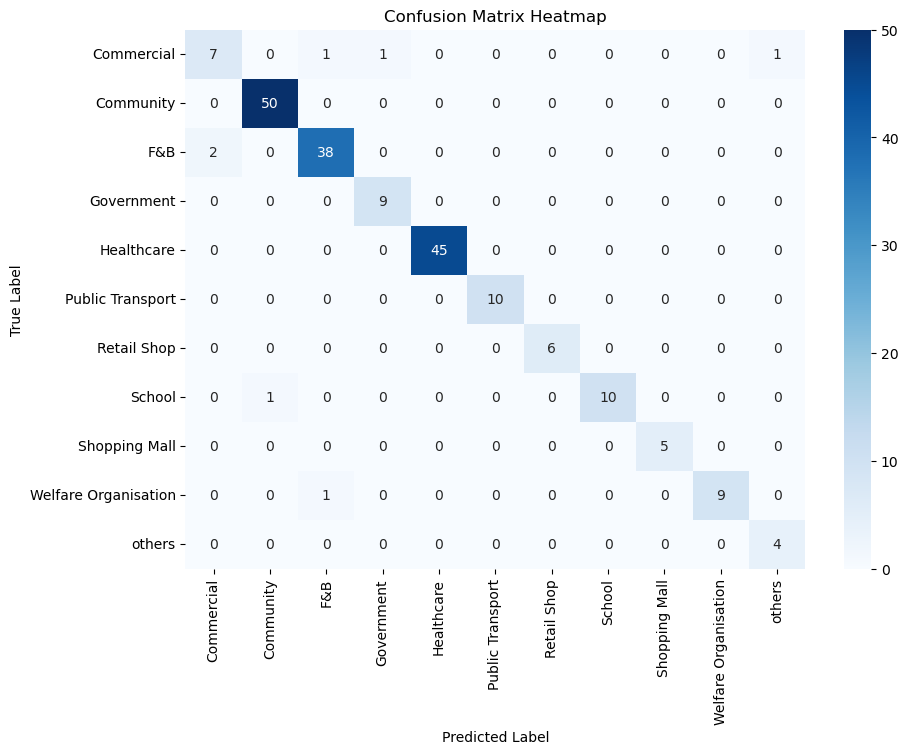

In [99]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test contains the true labels and y_pred contains the predicted labels

# Step 1: Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()
